# Datenquellen und Datenbank
In diesem Notebook werden die Datenquellen beschrieben sowie deren Herkunft. Aufgrund der grossen Datenmengen wird ein Data Warehouse angelegt. Dazu werden die Daten in eine SQLite Datenbank geladen. Dies erlaubt in der späteren Auswertungen vordefinierte Views zu erstellen und diese für die weitere Verwendung zu nutzen.

> !! Dieses Notebook muss zuerst ausgeführt werden, damit die Datenbank erstellt wird. Sie ist zu gross um diese direkt in Github hochzuladen. !!

## Eingesetzte Module
Für dieses Notebook werden folgende Module eingesetzt:
- __sqlite3__
    Wird für die Datenbank verwendet
- __pandas__ 
    Wird gebraucht um die CSV Dateien zu lesen und als Dataframe in die SQLite Datenbank zu laden
- __numpy__
    Wird benötigt um die NaN Werte in den Dataframes mit NULL zu ersetzen
- __glob__
    Wird eingesetzt um gesamte Folders in einem Loop in die SQLite Datenbank zu laden

In [13]:
#Import Modules
import os, sqlite3
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Datenbank
Zur Untersuchung, welche Einflussfaktoren den Stromverbrauch der Gemeinden im Kanton Luzern beeinflussen können, wird auf mehrere Datenquellen zurückgegriffen. Die Datenquellen sind nachfolgend aufgelistet und werden im weiteren Verlauf beschrieben:
- Smartmeter Daten der CKW AG
- Demografische Daten des Bundes
- Solarkraftwerke Daten des Bundes
- Historische Meteo Daten des Bundes
- Gemeindenamen und BFS-ID von Swisstopo

Die genannten Datenquellen werden mit folgendem ERD in die SQLite Datenbank geladen.

> ![ERD-Diagramm](./DATA/ERD_BINA_V4.png)

Die Erläuterungen, zu den einzelnen Tabellen, folgt bei den jeweiligen Datenimporten.

### Eigenschaften der SQLite Datenbank
Die SQLite Datenbank hat gewisse Einschränkungen und Eigenheiten die beachtet werden müssen. Dies weil SQLite nicht alle Formate oder Datentypen unterstützt. Die relevanten Aspekte werden in diesem Kapitel kurz erläutert.

__Strings__
Damit SQLite die Daten als String erkennt müssen diese in "" eingebettet werden. Ansonsten wird eine Fehlermeldung ausgegeben. Die Datentypen aus den Pandas Dataframes werden nicht in die SQLite Datenbank mitübergeben.

__Datum__
SQLite kennt keinen Datum-Datentyp. Dementsprechend müssen die Datum-/Zeitstempel in einem spezifischen String-Format gespeichert werden. Eine entsprechende Umformung muss daher bereits vor dem Import erfolgen, ansonsten funktionieren die SQLite Datum-/Zeitfunktionen nicht bei den abfragen. Die unterstützten Formate sind in dieser [Dokumentation](https://www.sqlite.org/lang_datefunc.html) gelistet. Für diese Arbeit sind folgende Formate relevant:
- YYYY-MM-DDTHH:MM:SS.SSS 
- YYYY-MM-DD HH:MM

So können Datumabfragen erstellt werden wie im nachfolgenden Beispiel
> `SELECT MAX(strftime('%Y-%m-%d %H:%M', dataTime)) FROM meteoData;`

__Automatische ID__
Damit automatisch ein eindeutiger Primary Key generiert wird muss beim Import der Daten, der Platzhalter für das ID-Attribut leergelassen werden und mit NULL gefüllt werden. So wird automatisch ein Primary Key vergeben.

__No Value Handling__
Leere Werte in den Datenquellen welche mit nan, NaN, na, etc. gelistet sind, müssen mit NULL ersetzt werden. Sonst wird der Wert als String interpretiert und gibt einen Fehler aus, wenn es sich um numerische Werte handelt.

### Erstellen des Datenbank Files
Hier wird die Datenbank angelegt. Ist das File nicht vorhanden, wird dieses automatisch angelegt.

In [14]:
# creating file (path) name
dbfile = './DATA/BINA_DATA.db' 

# Test if the database file is available in the colab workspace
if os.path.exists(dbfile):
    # Create database (file) and Open a (SQL) connection 
    connection = sqlite3.connect(dbfile)
    # Create a data cursor to exchange information between Python and SQLite
    cursor = connection.cursor()
else:
    print("Angegebene Database wurde nicht gefunden")
    # Create database (file) and Open a (SQL) connection 
    connection = sqlite3.connect(dbfile)
    # Create a data cursor to exchange information between Python and SQLite
    cursor = connection.cursor()
    #sys.exit(0)


Angegebene Database wurde nicht gefunden


### Tabellen erstellen
Basierend auf dem ERD werden die Tabellen in der Datenbank angelegt. Entsprechend werden die Primary Keys definierte und die Abhängigkeiten referenziert.

In [15]:
# Tabelle erstellen
sql = ["CREATE TABLE city (id INTEGER PRIMARY KEY, plz string, cityName string, bfsID string, lawCityName string, kantonkuerzel string)",
"CREATE TABLE smartmeter (id INTEGER PRIMARY KEY, plz REFERENCES city(plz) ON UPDATE CASCADE, timestamp string, anzMeter int,valueKwh float)",
"CREATE TABLE solarPlants (id INTEGER PRIMARY KEY, xtfID string, plz string, canton string, totalPower float, mainCategory string, subCategory string, plantCategory string,  _x int,  _y int, FOREIGN KEY (plz) REFERENCES city(plz) ON UPDATE CASCADE, FOREIGN KEY (subCategory) REFERENCES subCategory(id) ON UPDATE CASCADE, FOREIGN KEY (mainCategory) REFERENCES mainCategory(id) ON UPDATE CASCADE, FOREIGN KEY (plantCategory) REFERENCES plantCategory(id) ON UPDATE CASCADE)",
"CREATE TABLE mainCategory (id string PRIMARY KEY, de string, fr string, it string, en string)",
"CREATE TABLE plantCategory (id string PRIMARY KEY, de string, fr string, it string, en string)",
"CREATE TABLE subCategory (id string PRIMARY KEY, de string, fr string, it string, en string)",
"CREATE TABLE indicator (id string PRIMARY KEY, descr string)",
"CREATE TABLE unit (id string,  mes string)",
"CREATE TABLE demoValue (id INTEGER PRIMARY KEY, bfsID string, period string, indicator string, unit string, value float, FOREIGN KEY (bfsID) REFERENCES city(bfsID) ON UPDATE CASCADE, FOREIGN KEY (indicator) REFERENCES indicator (id) ON UPDATE CASCADE, FOREIGN KEY (unit) REFERENCES unit(id) ON UPDATE CASCADE)",
"CREATE TABLE meteoParameter (parameterID string PRIMARY KEY , measure string, description string)",
"CREATE TABLE meteoStations (stn string PRIMARY KEY, stnName string, lawCityName string,  datasource string, bfsID string, coEast string, coNorth string, coLength string, coWide string, FOREIGN KEY (lawCityName) REFERENCES city (lawCityName) ON UPDATE CASCADE, FOREIGN KEY (bfsID) REFERENCES city (bfsID) ON UPDATE CASCADE)",
"CREATE TABLE meteoData (id INTEGER PRIMARY KEY, meteoStation string, meteoParameter string, dataTime string, value float, FOREIGN KEY (meteoStation) REFERENCES meteoStations (stn) ON UPDATE CASCADE, FOREIGN KEY (meteoParameter) REFERENCES meteoParameter (parameterID) ON UPDATE CASCADE)",
"CREATE TABLE meteoParamBfs (id INTEGER PRIMARY KEY, bfsID string, meteoParameter string, meteoStation string, FOREIGN KEY (bfsID) REFERENCES city (bfsID) ON UPDATE CASCADE, FOREIGN KEY (meteoParameter) References meteoParameter (parameterID) ON UPDATE CASCADE, FOREIGN KEY (meteoStation) REFERENCES meteoStations (stn) ON UPDATE CASCADE)",
"CREATE TABLE plzBfsMapping (id INTEGER PRIMARY KEY, plz string, bfsID string, cityName string, lawCityName string)"]

for code in sql:
    cursor.execute(code)
    

### Views erstellen
Diese Views helfen in der späteren Datenanalyse und können direkt in ein Dataframe geladen werden für die weitere Verwendung.

Um einen einfacheren Zugang zu bestimmten Daten zu haben, wurden entsprechende Views generiert. Diese filtern im Beispiel der demografischen Daten die verschiedenen Indikatoren oder verbinden die Daten zwischen mehreren Datensätzen und summieren diese. So können für spätere Auswertungen bereits vorgefertigte Daten verwendet werden.

Folgende Views wurden erstellt:
- **population:** Gibt die Bevölkerung zur BFS-ID in einer bestimmten Periode an.
- **populationDensity:** Gibt die Bevölkerungsdichte zur BFS-ID in einer bestimmten Periode an.
- **areaTotal:** Gibt die Fläche zur BFS-ID in einer bestimmten Periode an.
- **areaSettlement:** Gibt die besiedelte Fläche zur BFS-ID in einer bestimmten Periode an.
- **areaAgricultural:** Gibt die Agrarfläche zur BFS-ID in einer bestimmten Periode an.
- **areaUnproductive:** Gibt die unproduktive Fläche zur BFS-ID in einer bestimmten Periode an.
- **keyFiguresPopulation:** Fasst die einzelnen Datensätze der Bevölkerung und der Bevölkerungsdichte pro BFS-ID und Periode zu einem Datensatz zusammen.
- **keyFiguresArea:** Fasst die einzelnen Datensätze der Fläche pro BFS-ID zu einem Datensatz zusammen, weist aber pro Wert die Periode aus.
- **sumSmartmeter:** Rechnet die KWh pro BFS-ID zusammen.
- **meteoStationsParameter:** Reichert die Daten der Meteo Stationen mit deren Standort an.
- **solarPlantsLU:** Gibt alle registrierten Solaranlagen im Kanton Luzern aus.
- **solarPlantsLUbfsId:** Gibt alle registrierten Solaranlagen im Kanton Luzern aus, gruppiert nach der BFS-ID.

In [16]:
# Views erstellen
sql = [ "CREATE VIEW population AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_01_01';",
        "CREATE VIEW populationDensity AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_01_03';",
        "CREATE VIEW areaTotal AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_01';",
        "CREATE VIEW areaSettlement AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_02';",
        "CREATE VIEW areaAgricultural AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_04';",
        "CREATE VIEW areaUnproductive AS SELECT id, bfsID, period, value FROM demoValue WHERE demoValue.indicator == 'Ind_04_07';",
        "CREATE VIEW keyFiguresPopulation as SELECT p.bfsID, p.period, p.value as population, pd.value as populationDensity FROM population p LEFT JOIN population_density pd ON p.bfsID = pd.bfsID AND p.period = pd.period;",
        "CREATE VIEW keyFiguresArea as SELECT a.bfsID, a.period as periodTotal, a.value as total,ase.period as periodSettlement, ase.value as settlement, aa.period as periodAgricultural, aa.value as agricultural, au.period as periodUnproductive, au.value as unproductive FROM areaTotal a LEFT JOIN areaSettlement ase ON a.bfsID = ase.bfsID LEFT JOIN areaAgricultural aa ON a.bfsID = aa.bfsID LEFT JOIN areaUnproductive au ON a.bfsID = au.bfsID;",
        "CREATE VIEW sumSmartmeter as SELECT s.plz as plz, bfsID, SUM(valueKwh) as 'kWh' FROM smartmeter as s LEFT JOIN (SELECT plz, bfsID FROM city GROUP BY plz) as c ON s.plz = c.plz GROUP BY bfsID;",
        "CREATE VIEW meteoStationsParameter as SELECT DISTINCT meteoStations.bfsID, meteoStation, meteoParameter FROM meteoData LEFT JOIN meteoStations on meteoStations.stn = meteoData.meteoStation;",
        "CREATE VIEW solarPlantsLU as SELECT * FROM solarPlants WHERE solarPlants.Canton == 'LU' AND solarPlants.SubCategory == 'subcat_2';",
        "CREATE VIEW solarPlantsLUbfsId as SELECT SUM(s.totalPower), s.canton, p.lawCityName, p.bfsID FROM solarPlants as s LEFT JOIN plzBfsMapping as p ON s.plz = p.plz WHERE s.canton == 'LU' AND s.subCategory == 'subcat_2' GROUP BY p.bfsID;"
       ]

for code in sql:
    cursor.execute(code)

## Datenquellen
Nachfolgend werden die verwendeten Datenquellen beschrieben und ein erstes Mal analysiert.

### BFS-ID Verzeichnis
**Herausgeber:**
Bundesamt für Landestopografie Swisstopo

**Link:**
https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis#Ortschaftenverzeichnis--Download

**Beschreibung:**
Dieses Dataset beinhaltet das amtliche Ortschaftenverzeichnis. Eine Ortschaft ist mit einer eindeutigen Postleitzahl (PLZ) und Ortschaftsnamen bezeichnet. Diese Bezeichnungen sind relevant für die Postadresse und werden durch die Swisstopo erstellt, verwaltet und veröffentlicht (Swisstopo, [Online-Quelle](https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis)). Die BFS-Nr. wird vom Bundesamt für Statistik (BFS) jeder Gemeinde vergeben. Diese Nummern werden vom BFS erstellt, verwaltet und veröffentlicht. Diese sind im amtlichen Gemeindeverzeichnis ersichtlich (BFS, [Online-Quelle](https://www.bfs.admin.ch/bfs/de/home/grundlagen/agvch.html)). Dieses Dataset erlaubt die Übersetzung zwischen BFS-Nr. <-> PLZ.

**Zeitraum:**
Das Dataset wurde am 25.3.2024 heruntergeladen. Dementsprechend ist das Dataset auf dem gültigen Stand vom 1.3.2024, da dieses Dataset von Swisstopo immer am ersten Tag im Monat aktualisiert wird (Swisstopo, [Online-Quelle](https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis)).

**Zweckerfüllung:**
Zur Beantwortung der Forschungsfrage werden diverse Datasets mit einander verbunden. Da die Datasets mit unterschiedlichen Gemeinde-Informationen bzw. Ortschaftsinformationen arbeiten wird eine Übersetzung zwischen der BFS-ID und der PLZ benötigt. Beispielsweise arbeitet das BFS ausschliesslich mit der BFS-ID, die Smartmeter Daten werden auf die PLZ geschlüsselt. Damit die Daten nun miteinander in Beziehung gesetzt werden können, wird dieses Dataset von Swisstopo benötigt. 

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* Da es sich beim Bund um eine Primäre Quelle handelt, ist die Glaubwürdigkeit gegeben.

*Nützlichkeit:* Die Daten sind vollständig und erlauben die notwendige Übersetzung mit einer gewissen Limitierung welche noch genauer erläutert wird.

*Interpretierbarkeit:* Das Dataset ist leicht verständlich und kann ohne weiteres Interpretiert werden.

*Schlüsselintegrität:* Ein eindeutiger Schlüssel ist im Dataset nicht vorhanden.

**Verfügbarkeit:** Das Dataset ist öffentlich verfügbar und kann durch jede Person heruntergeladen werden.

**Preis:** Das Dataset wird kostenlos zu Verfügung gestellt.

#### Inhaltliche Analyse und Schwierigkeiten 
Es sind zehn Spalten in dem CSV Dataset vorhanden mit Total 5733 Zeilen. Die Spalten sind selbstsprechend. Die Spalte "Zusatzziffer" ist eine Post interne Ziffer und ist für die weiterführende Analyse nicht relevant. Auffallend sind die 20 null Werte in der Spalte "Kantonskürzel".
Ortschaft entspricht nicht der Gemeinde und umgekehrt

In [17]:
# City Daten einlesen als Dataframe und in DB sichern
city_df = pd.read_csv("./DATA/city_directory/AMTOVZ_CSV_LV95.csv", delimiter=";")
city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ortschaftsname  5733 non-null   object 
 1   PLZ             5733 non-null   int64  
 2   Zusatzziffer    5733 non-null   int64  
 3   Gemeindename    5733 non-null   object 
 4   BFS-Nr          5733 non-null   int64  
 5   Kantonskürzel   5713 non-null   object 
 6   E               5733 non-null   float64
 7   N               5733 non-null   float64
 8   Sprache         5733 non-null   object 
 9   Validity        5733 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 448.0+ KB


Wie nachfolgend ersichtlich ist, werden die Liechtensteiner Ortschaften ebenfalls in diesem Dataset geführt. Da diese keinem Kanton angehören, sind diese Werte entsprechend leer, daraus resultieren die null Werte.

In [18]:
df = city_df[city_df['Kantonskürzel'].isnull()]
print(df)

       Ortschaftsname   PLZ  Zusatzziffer  Gemeindename  BFS-Nr Kantonskürzel  \
5713  Gamprin-Bendern  9487             0         Vaduz    7001           NaN   
5714            Vaduz  9490             0         Vaduz    7001           NaN   
5715           Schaan  9494             0         Vaduz    7001           NaN   
5716      Triesenberg  9497             0         Vaduz    7001           NaN   
5717          Triesen  9495             0       Triesen    7002           NaN   
5718          Balzers  9496             0       Balzers    7003           NaN   
5719      Triesenberg  9497             0   Triesenberg    7004           NaN   
5720           Schaan  9494             0        Schaan    7005           NaN   
5721      Triesenberg  9497             0        Schaan    7005           NaN   
5722          Planken  9498             0       Planken    7006           NaN   
5723          Nendeln  9485             0        Eschen    7007           NaN   
5724  Gamprin-Bendern  9487 

Wenn ein erster Blick auf die ersten Zeilen des Datasets geworfen wird, fällt gleich auf, dass eine PLZ mehrere Ortschaftsnamen haben kann. Umgekehrt kann eine BFS-Nr mehreren Ortschaften mit auch unterschiedlicher PLZ zugewiesen werden. Dies macht die gesamte Übersetzung nicht einfach. Ein weiterer Indikator für diese Schwierigkeit sind die Anzahl eindeutiger Werte bei der PLZ und der BFS-Nr.

In [19]:
print("Anz. Eindeutige PLZ:",len(city_df['PLZ'].unique()), "\nAnz. Eindeutige BFS-Nr:", len(city_df['BFS-Nr'].unique()))
city_df.head(10)

Anz. Eindeutige PLZ: 3194 
Anz. Eindeutige BFS-Nr: 2143


,Ortschaftsname,PLZ,Zusatzziffer,Gemeindename,BFS-Nr,Kantonskürzel,E,N,Sprache,Validity
0,Aeugst am Albis,8914,0,Aeugst am Albis,1,ZH,2679402.872,1235842.010,de,2008-07-01
1,Aeugstertal,8914,2,Aeugst am Albis,1,ZH,2679815.372,1237404.310,de,2008-07-01
2,Zwillikon,8909,0,Affoltern am Albis,2,ZH,2675280.133,1238108.286,de,2008-07-01
3,Affoltern am Albis,8910,0,Affoltern am Albis,2,ZH,2676852.012,1236929.718,de,2008-07-01
4,Bonstetten,8906,0,Bonstetten,3,ZH,2677412.150,1241078.278,de,2008-07-01
5,Sihlbrugg,6340,4,Hausen am Albis,4,ZH,2686082.431,1230649.176,de,2008-07-01
6,Langnau am Albis,8135,0,Hausen am Albis,4,ZH,2682031.828,1235594.870,de,2008-07-01
7,Hausen am Albis,8915,0,Hausen am Albis,4,ZH,2682851.794,1233662.737,de,2008-07-01
8,Ebertswil,8925,0,Hausen am Albis,4,ZH,2684421.805,1231375.039,de,2008-07-01
9,Hedingen,8908,0,Hedingen,5,ZH,2676516.423,1239543.573,de,2008-07-01


Besonders gut ersichtlich ist dies mit der Ortschaft/Gemeinde Entlebuch. Diese wird als Ortschaft mit der PLZ 6162 geführt, gehört aber einmal zu der Gemeinde Hasle mit der BFS-Nr. 1005 und einmal zu der eigenständige Gemeinde Entlebuch mit der BFS-Nr. 1002. Aus diesem Grund muss manuell für den Kanton Luzern (auf diesen Kanton beschränken sich die Stromzähler-Daten) eine gültiges Mapping erstellt werden, damit die statistischen Daten korrekt miteinander verknüpft werden können.

In [20]:
df = city_df.query('Ortschaftsname == "Entlebuch" or Gemeindename == "Entlebuch"')
df.head(100)

,Ortschaftsname,PLZ,Zusatzziffer,Gemeindename,BFS-Nr,Kantonskürzel,E,N,Sprache,Validity
1302,Schachen LU,6105,0,Entlebuch,1002,LU,2651765.170,1206458.353,de,2008-07-01
1303,Wolhusen,6110,0,Entlebuch,1002,LU,2647835.016,1209085.303,de,2008-07-01
1304,Entlebuch,6162,0,Entlebuch,1002,LU,2648181.509,1204613.219,de,2008-07-01
1305,Rengg,6162,2,Entlebuch,1002,LU,2651085.330,1206090.284,de,2008-07-01
1306,Finsterwald b. Entlebuch,6162,3,Entlebuch,1002,LU,2651398.164,1196309.788,de,2008-07-01
1307,Ebnet,6163,0,Entlebuch,1002,LU,2649189.420,1207868.916,de,2008-07-01
1308,Hasle LU,6166,0,Entlebuch,1002,LU,2643949.810,1203182.068,de,2008-07-01
1309,Schüpfheim,6170,0,Entlebuch,1002,LU,2643913.598,1202607.042,de,2008-07-01
1315,Entlebuch,6162,0,Hasle (LU),1005,LU,2647203.726,1204928.665,de,2008-07-01


Mit den nachfolgenden Codezeilen werden die Daten in die city-Tabelle eingelesen.

In [21]:
for index, row in city_df.iterrows():
    ort = '"' + row["Ortschaftsname"] + '"'
    lawCityName = '"' + row["Gemeindename"] + '"'
    if isinstance(row["Kantonskürzel"], str):
        kantonkuerzel = '"' + row["Kantonskürzel"] + '"'
    else:
        kantonkuerzel = "NULL"
    sql = "INSERT INTO city VALUES(NULL,{},{},{},{},{})".format(row["PLZ"], ort, row["BFS-Nr"], lawCityName, kantonkuerzel)
    cursor.execute(sql)

connection.commit()

#### Mapping BFS-Nr. <-> PLZ
Um eine eindeutige Zuordnung zwischen PLZ und BFS-Nr zu haben, wurde die Liste der Luzerner Gemeinden händisch bearbeitet. Das Ziel war es jede PLZ eindeutig einer BFS-ID zuzuordnen, wobei aber mehrere verschiedene PLZ auf dieselbe BFS-ID verweisen können. Dazu wurden zuerst sämtliche Gemeinden vom Kanton Luzern aus dem City Directory exportiert. In diesem Datensatz wurden sämtliche, doppelt vorhandenen PLZ identifiziert und geprüft, welches die "Hauptgemeinde" hinder der PLZ darstellt und welche Ortschaften auch bereits mit einer anderen BFS-ID verknüpft sind. Solche Einträge wurden entfernt. Ausser bei einer Ausnahme konnten so sämtliche, doppelten PLZ entfernt werden, wobei darauf geachtet werden musste, dass nicht keine BFS-ID komplett entfernt wird und so keine zugewiesene PLZ mehr hat.

Die Ausnahme bilden Gisikon und Honau, welche zwar identische PLZ (6038) aufweisen, jedoch unterschiedliche BFS-IDs haben. Die BFS-IDs sind einmalig, bedeutet beim Entfernen einer der beiden Datensätze verschwindet eine Markierung auf der Karte. Da anhand der PLZ keine Unterscheidung vorgenommen werden kann, wurde die Entscheidung getroffen, den Datensatz von Honau zu entfernen und nur mit Gisikon zu arbeiten.

Verweisen mehrere PLZ auf dieselbe BFS-ID müssen bei den Auswertungen für die MAP am Ende die Werte zusammengerechnet werden für akkurate Darstellungen.


In [22]:
mapping = pd.read_csv("./DATA/city_directory/mapping_plz_bfsid_lu.csv", delimiter=",")

for index, row in mapping.iterrows():
    cityName = '"' + row["cityName"] + '"'
    lawCityName = '"' + row["lawCityName"] + '"'

    sql = "INSERT INTO plzBfsMapping VALUES(NULL,{},{},{},{})".format(row["plz"], row["bfsId"], cityName, lawCityName)
    cursor.execute(sql)

connection.commit()

### Verbaute Solaranlagen
**Herausgeber:**
Bundesamt für Energie (BFE)

**Link:**
https://opendata.swiss/de/dataset/elektrizitatsproduktionsanlagen

**Beschreibung:**
In diesem Dataset sind sämtliche registrierte Elektrizität Produktionsanlagen hinterlegt. Diese Daten basieren auf dem Herkunftsnachweissystem (HKN). In diesem System sind sämtliche Anlagen registriert welche über 30 Kilovoltampere (kVA) bzw. 30 Kilowatt (KW). Zudem sind Kleinanlagen welche über 2 KW produzieren registriert, den Beitreibern steht es aber frei, ob sie sich registrieren möchten. Die Registrierung ist notwendig für einen Herkunftsnachweis. Dieser ist Voraussetzung, wenn Strom in das Netz eingespiesen werden möchte. Es sind nur Anlagen gelistet, welche aktuell in Betrieb sind. Es wird monatlich aktualisiert (BFE, [Online-Quelle](https://www.uvek-gis.admin.ch/BFE/storymaps/EE_Elektrizitaetsproduktionsanlagen/)).

**Zeitraum:**
Das Dataset wurde am 24.3.2024 heruntergeladen. Dementsprechend ist das Dataset auf dem gültigen Stand vom Monat März, da dieses Dataset vom BFE monatlich aktualisiert wird. Es sind nur aktive Anlagen gelistet (OpenData, [Online-Quelle](https://opendata.swiss/de/dataset/elektrizitatsproduktionsanlagen)).

**Zweckerfüllung:**
In diesem Dataset befinden sich diverse Kraftwerks-Kategorien. Für diese Arbeit sind besonders die Photovoltaik-Anlagen von Privaten interessant. Dies erschliesst sich daraus, dass mit der Sonne und einer Photovoltaik-Anlage der Strom selbst verbraucht werden kann. Aus Sicht des Energieversorgers sinkt dadurch der Strombedarf und müsste in den Smartmeter-Daten ersichtlich sein. Daher erfüllt dieses Dataset seinen Zweck, in dem des vorhandene Anlagen inkl. verbaute Leistung liefert. Nähere Infos folgen in der tieferen Analyse.

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* Es handelt sich im primäre Daten welche durch das BFE veröffentlicht werden. Dementsprechend ist die Glaubwürdigkeit gegeben. Wie in der Analyse festgestellt wurde, ist die Qualität der Adressen wohl nicht geprüft worden durch eine amtliche Stelle. Wie später beschrieben wird, wurden diverse Schreibfehler und Zahlendreher festgestellt.

*Nützlichkeit:* Die Daten können für den vorgesehenen Zweck verwendet werden. Sie basieren auf aktuellen Daten aus dem HKN. Weiter wird ein Datum des Produktionsbetriebes angegeben, was eine zeitliche Schlussfolgerung zusammen mit den Smartmeter Daten und weiteren Daten zulässt.

*Interpretierbarkeit:* Das Dataset besteht aus sechs CSV-Dateien welche zusammen eine Datenbank in Normalform darstellen. Die Spalten sind klingend benannt. Was nicht intuitiv verständlich ist, sind die drei verschiedenen Kategorie-Katalogen (MainCategoryCatalogue, PlantCategoryCatalogue, SubCategoryCatalogue). Am Aussagekräftigsten ist die SubCategoryCatalogue Datei. Sie gibt direkt an, um welchen erneuerbaren Kraftwerktyp es sich handelt. Die Datei PlantDetail ist nicht relevant, da sie im Dataset nicht referenziert wird. Mit diesem Wissen ist die Interpretierbarkeit gegeben. Nähere Details folgen in der Analyse.

*Schlüsselintegrität:* Die Hauptdatei ist die ElectricityProductionPlant. In dieser ist jedes Kraftwerk mit der xtf_id eindeutig identifizierbar. Jedes Kraftwerk verfügt über mehrere ForeignKey's welche auf die entsprechenden Kategorien geschlüsselt sind. 

**Verfügbarkeit:** Das Dataset ist öffentlich verfügbar und kann durch jede Person heruntergeladen werden.

**Preis:** Das Dataset wird kostenlos zu Verfügung gestellt.

#### Inhaltliche Analyse und Schwierigkeiten 
Die drei relevanten CSV-Dateien MainCategoryCatalogue, PlantCategoryCatalogue und SubCategoryCatalogue sind ausgelagerte Kategorien Definitionen. Diese Dateien sind immer gleich aufgebaut. Zuerst wird die ID angegeben und anschliessend die jeweilige Textbeschreibung in verschiedenen Sprachen (de, fr, it und en). In der PlantCategoryCatalogue Datei werden die detaillierten Kraftwerkstypen angegeben.

In [23]:
plantCategory = pd.read_csv("./DATA/solar_powerplants/PlantCategoryCatalogue.csv", delimiter=",")
plantCategory.head(100)

,Catalogue_id,de,fr,it,en
0,plantcat_1,Abwasserkraftwerk,Centrale sur les eaux usées,Centrale ad acqua di scarico,Wastewater power plant
1,plantcat_2,Ausleitkraftwerk,Centrale de dérivation,Centrale a derivazione,Diversion power plant
2,plantcat_3,Dotierwasserkraftwerk,Centrale de dotation,Centrale ad acqua di dotazione,Weir plant
3,plantcat_4,Durchlaufkraftwerk,Centrale au fil de l’eau,Centrale ad acque di deflusso,Continuous power plant
4,plantcat_5,Trinkwasserkraftwerk,Centrale sur l’eau potable,Centrale ad acqua potabile,Drinking water power plant
5,plantcat_6,Pumpspeicherkraftwerk,Centrale de pompage-turbinage,Centrale di pompaggio-turbinaggio,Pumped storage power plant
6,plantcat_7,Speicherkraftwerk,Centrale à accumulation,Centrale ad accumulazione,Storage power plant
7,plantcat_8,Angebaut,Ajoutée,Annesso,Attached
8,plantcat_9,Integriert,Intégrée,Integrato,Integrated
9,plantcat_10,Freistehend,Isolée,Isolato,Freestanding


Laden der CSV Datei in die SQLite Datenbank.

In [24]:
for index, row in plantCategory.iterrows():
    catalogueId = '"' + row["Catalogue_id"] + '"'
    de = '"' + row["de"] + '"'
    fr = '"' + row["fr"] + '"'
    it = '"' + row["it"] + '"'
    en = '"' + row["en"] + '"'
    sql = "INSERT INTO plantCategory VALUES({},{},{},{},{})".format(catalogueId, de, fr, it, en)
    cursor.execute(sql)

connection.commit()

Die MainCategoryCatalogue Datei liefert die Haupt-Kraftwerkskategorien. Hier wird unterschieden aus welchem Energieträger Strom produziert wird. Für die vorliegende Arbeit ist die maincat_2 "Übrige erneuerbaren Energien" relevant.

In [25]:
mainCategory = pd.read_csv("./DATA/solar_powerplants/MainCategoryCatalogue.csv", delimiter=",")
mainCategory.info()
mainCategory.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Catalogue_id  4 non-null      object
 1   de            4 non-null      object
 2   fr            4 non-null      object
 3   it            4 non-null      object
 4   en            4 non-null      object
dtypes: object(5)
memory usage: 288.0+ bytes


,Catalogue_id,de,fr,it,en
0,maincat_1,Wasserkraft,Énergie hydraulique,Forza idrica,Hydroelectric power
1,maincat_2,Übrige erneuerbare Energien,Autres énergies renouvelables,Altre energie rinnovabili,Other renewable energies
2,maincat_3,Kernenergie,Énergie nucléaire,Energia nucleare,Nuclear energy
3,maincat_4,Fossile Energieträger,Agents énergétiques fossiles,Vettori energetici fossili,Fossil fuel


Laden der CSV Datei in die SQLite Datenbank.

In [26]:
for index, row in mainCategory.iterrows():
    catalogueId = '"' + row["Catalogue_id"] + '"'
    de = '"' + row["de"] + '"'
    fr = '"' + row["fr"] + '"'
    it = '"' + row["it"] + '"'
    en = '"' + row["en"] + '"'
    sql = "INSERT INTO mainCategory VALUES({},{},{},{},{})".format(catalogueId, de, fr, it, en)
    cursor.execute(sql)

connection.commit()

Wie in der Interpretierbarkeit erläutert ist die SubCategoryCatalogue Datei die aussagekräftigste für diese Arbeit. Mit der subcat_2 ID werden alle Photovoltaik Produktionsanlagen beschrieben.

In [27]:
# Importieren der Unterkategorien
subCategory = pd.read_csv("./DATA/solar_powerplants/SubCategoryCatalogue.csv", delimiter=",")
subCategory.info()
subCategory.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Catalogue_id  10 non-null     object
 1   de            10 non-null     object
 2   fr            10 non-null     object
 3   it            10 non-null     object
 4   en            10 non-null     object
dtypes: object(5)
memory usage: 528.0+ bytes


,Catalogue_id,de,fr,it,en
0,subcat_1,Wasserkraft,Énergie hydraulique,Forza idrica,Hydroelectric power
1,subcat_2,Photovoltaik,Photovoltaïque,Energia fotovoltaica,Photovoltaic
2,subcat_3,Windenergie,Énergie éolienne,Energia eolica,Wind energy
3,subcat_4,Biomasse,Biomasse,Biomassa,Biomass
4,subcat_5,Geothermie,Géothermie,Geotermia,Geothermal energy
5,subcat_6,Kernenergie,Énergie nucléaire,Energia nucleare,Nuclear energy
6,subcat_7,Erdöl,Pétrole,Petrolio,Crude oil
7,subcat_8,Erdgas,Gaz naturel,Gas naturale,Natural gas
8,subcat_9,Kohle,Charbon,Carbone,Coal
9,subcat_10,Abfälle,Déchets,Rifiuti,Waste


Laden der CSV Datei in die SQLite Datenbank.

In [28]:
for index, row in subCategory.iterrows():
    catalogueId = '"' + row["Catalogue_id"] + '"'
    de = '"' + row["de"] + '"'
    fr = '"' + row["fr"] + '"'
    it = '"' + row["it"] + '"'
    en = '"' + row["en"] + '"'
    sql = "INSERT INTO subCategory VALUES({},{},{},{},{})".format(catalogueId, de, fr, it, en)
    cursor.execute(sql)

connection.commit()

Die Hauptdatei ElectricityProductionPlant beinhaltet 203473 Anlagen. Die Datei ist nicht komplett. Die PlantCategory sowie die Koordinaten sind nicht für sämtliche Anlagen gepflegt. Dies stellt für die weitere Analyse kein Problem dar da für jede Anlage eine Adresse mit PLZ und Ortsname verfügbar. Dadurch können diese Kraftwerke direkt einer Smartmeter Gemeinde zugewiesen werden. Die PlantCategory ist sekundär, da die SubCategory relevant ist.

In [29]:
# Importieren der Solar Kraftanlagen
electricityProductionPlant = pd.read_csv("./DATA/solar_powerplants/ElectricityProductionPlant.csv", delimiter=",")
electricityProductionPlant.info()
electricityProductionPlant.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203474 entries, 0 to 203473
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   xtf_id                203474 non-null  int64  
 1   Address               203474 non-null  object 
 2   PostCode              203474 non-null  int64  
 3   Municipality          203474 non-null  object 
 4   Canton                203474 non-null  object 
 5   BeginningOfOperation  203474 non-null  object 
 6   InitialPower          203474 non-null  float64
 7   TotalPower            203474 non-null  float64
 8   MainCategory          203474 non-null  object 
 9   SubCategory           203474 non-null  object 
 10  PlantCategory         198553 non-null  object 
 11  _x                    196057 non-null  float64
 12  _y                    196057 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 20.2+ MB


,xtf_id,Address,PostCode,Municipality,Canton,BeginningOfOperation,InitialPower,TotalPower,MainCategory,SubCategory,PlantCategory,_x,_y
0,14727,Schlossstrasse 15,4147,Aesch BL,BL,2009-05-05,14.65,18.81,maincat_2,subcat_2,plantcat_9,2611936.0,1257011.0
1,14728,Ob der Steig 1,5082,Kaisten,AG,2011-10-28,5.80,5.80,maincat_2,subcat_2,plantcat_8,2645758.0,1265094.0
2,10164,Gässli 4,3114,Wichtrach,BE,2008-10-07,3.00,3.00,maincat_2,subcat_2,plantcat_8,2610547.0,1188979.0
3,10794,Diemtigtalstrasse 46,3753,Oey,BE,2008-06-27,8.40,8.40,maincat_2,subcat_2,plantcat_8,2610529.0,1167346.0
4,9476,Holzweidstrasse 8,8340,Hinwil,ZH,2006-04-21,4.80,4.80,maincat_2,subcat_2,plantcat_8,2705863.0,1240553.0
5,14729,Lärchentobelstrasse 33,8700,Küsnacht,ZH,2010-11-04,21.80,21.80,maincat_2,subcat_2,plantcat_9,2687331.0,1241205.0
6,14730,Schulhaustrasse 24,9470,Buchs,SG,2008-09-24,3.60,3.60,maincat_2,subcat_2,plantcat_8,2754146.0,1225474.0
7,9365,Renggerstrasse 58,5000,Aarau,AG,2006-09-14,1.60,1.60,maincat_2,subcat_2,plantcat_8,2645858.0,1248560.0
8,14742,Gartenweg 8,5018,Erlinsbach,AG,2011-09-19,7.70,7.70,maincat_2,subcat_2,plantcat_9,2643326.0,1250567.0
9,14747,Hofbergstrasse 21,9500,Wil,SG,2011-12-16,50.90,50.90,maincat_2,subcat_2,plantcat_9,2721432.0,1258999.0


Im Kanton Luzern sind 10238 Anlagen registriert. In diesem Subset gibt es ebenfalls Lücken im Bereich der Koordinaten und PlantCategory. Die unten dargestellte Tabelle zeigt die totale Produktionsleistung gruppiert nach den Gemeinden. In dieser Tabelle wird ersichtlich, dass einige Schreibfehler vorhanden sind und dadurch die Gruppierung verfälschen.

In [30]:
electricityProductionPlantLU = electricityProductionPlant.query('Canton == "LU" and SubCategory == "subcat_2"')
print("\nAnzahl Solaranlagen im Kanton Luzern: ", len(electricityProductionPlantLU), "\n")
electricityProductionPlantLU.info()
electricityProductionPlantLU[["Municipality", "TotalPower"]].groupby('Municipality').sum()



Anzahl Solaranlagen im Kanton Luzern:  10238 

<class 'pandas.core.frame.DataFrame'>
Index: 10238 entries, 32 to 203462
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   xtf_id                10238 non-null  int64  
 1   Address               10238 non-null  object 
 2   PostCode              10238 non-null  int64  
 3   Municipality          10238 non-null  object 
 4   Canton                10238 non-null  object 
 5   BeginningOfOperation  10238 non-null  object 
 6   InitialPower          10238 non-null  float64
 7   TotalPower            10238 non-null  float64
 8   MainCategory          10238 non-null  object 
 9   SubCategory           10238 non-null  object 
 10  PlantCategory         10073 non-null  object 
 11  _x                    9932 non-null   float64
 12  _y                    9932 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 1.1+ MB


,TotalPower
Municipality,
Adligenswil,2225.49
Adlingenswil,23.02
Adsligenswil,13.53
Aesch,1566.78
Aesch,10.26
...,...
Wohlhusen,16.64
Wolhsuen,9.00
Wolhusen,5403.48


Aufgrund der Schreibfehler wird nach der PLZ gruppiert und in einer eigenen Datenbank View "solarPlantsLUbfsId" die Gemeindenamen sowie die BFS-ID hinzugefügt. Dadurch lassen sich die weiteren Daten miteinander verbinden. Während der Analyse im Zusammenhang mit dem verbinden der PLZ auf die BFS-ID wurde festgestellt, dass die PLZ 6000, 6002, 6011, 6021, 6161 und 6281 in der erstellten Tabelle gefehlt haben. Diese wurden entsprechend manuell nachgepflegt.

In [31]:
electricityProductionPlantLU[["PostCode", "TotalPower"]].groupby('PostCode').sum()

,TotalPower
PostCode,
4806,1238.15
4915,541.97
5735,612.36
6000,464.68
6002,1330.12
...,...
6353,2156.50
6354,829.58
6356,113.86


Während dem weiteren Mapping wurde festgestellt, dass die PLZ 6403 und 6312 nicht zum Kanton Luzern gehören. Wenn diese Einträge genau betrachtet werden, liegt der Verdacht nahe, dass diese Einträge nicht korrekt sind. Die PLZ 6312 wurde wohl falsch eingetippt und könnte 6212 St. Erhard LU sein, da auch die Adresse an diesen Ort verweist. Bei der PLZ 6403 wurde wohl der Kanton falsch angegeben. Diese Werte werden korrigiert aber auf eine weitere Validierung der Adressen wird aus zeitgründen verzichtet. Die Qualität der Daten wird durch die festgestellten Mängel gemindert.

In [32]:
electricityProductionPlantLU.query('PostCode == 6403 or PostCode == 6312')
electricityProductionPlant.at[101656, 'PostCode'] = 6212
electricityProductionPlant.at[138741, 'Canton'] = 'SZ'

In [33]:
electricityProductionPlant.query('xtf_id == 168209 or xtf_id == 218255')

,xtf_id,Address,PostCode,Municipality,Canton,BeginningOfOperation,InitialPower,TotalPower,MainCategory,SubCategory,PlantCategory,_x,_y
101656,168209,Im Wiberg 48,6212,St. Erhard,LU,2020-07-14,13.60,13.60,maincat_2,subcat_2,plantcat_8,2679696.0,1227599.0
138741,218255,Talstrasse 31A,6403,Küssnacht am rigi,SZ,2022-03-11,7.48,7.48,maincat_2,subcat_2,plantcat_8,2675871.0,1215913.0


Mit diesen Anpassungen und Erkenntnissen können die Daten in die Datenbank geladen werden. Weiter und tiefere Analyse folgen in den weiteren Schritten.
Vor dem Import werden die na Werte noch mit NULL überschrieben, damit die SQLite Datenbank diese als solche versteht.

In [34]:
electricityProductionPlant.replace(np.nan, "NULL", inplace=True)
for index, row in electricityProductionPlant.iterrows():
    mainCategoryId = '"' + row["MainCategory"] + '"'
    subCategoryId = '"' + row["SubCategory"] + '"'
    canton = '"' + row["Canton"] + '"'
    xCor = row["_x"]
    yCor = row["_y"]
    
    if isinstance(row["PlantCategory"], str):
        plantCategoryId = '"' + row["PlantCategory"] + '"'
    else:
        plantCategoryId = "NULL"
        
    sql = "INSERT INTO solarPlants VALUES(NULL,{},{},{},{},{},{},{},{},{})".format(row["xtf_id"], row["PostCode"], canton, row["TotalPower"], mainCategoryId, subCategoryId, plantCategoryId, xCor, yCor)
    cursor.execute(sql)
    
connection.commit()

In [35]:
#Importieren Demografie Daten Indikator
demoIndicator = pd.read_csv("./DATA/key_figures_communities/Indicator_DemoData.csv", delimiter=";")

for index, row in demoIndicator.iterrows():
    indicatorId = '"' + row["INDICATORS"] + '"'
    de = '"' + row["DE"] + '"'
    
    sql = "INSERT INTO indicator VALUES({},{})".format(indicatorId, de)
    cursor.execute(sql)
    
connection.commit()

In [36]:
#Importieren Unit Messeinheit
unitMeas = pd.read_csv("./DATA/key_figures_communities/unit_mes_DemoData.csv", delimiter=";")

for index, row in unitMeas.iterrows():
    unitMeasId = '"' + row["UNIT_MES"] + '"'
    unit = '"' + row["Einheit"] + '"'
    
    sql = "INSERT INTO unit VALUES({}, {})".format(unitMeasId, unit)
    cursor.execute(sql)

connection.commit()

In [37]:
#Importieren demoValue
demoValue = pd.read_csv("./DATA/key_figures_communities/ts-x-21.03.01.csv", delimiter=";", dtype={'PERIOD_REF': str, 'PERIOD_COMP': str, 'REGION': str})
demoValue.replace("CH", 0, inplace=True)
demoValue.replace(np.nan, "NULL", inplace=True)

for index, row in demoValue.iterrows():
    period = row["PERIOD_REF"]
    if isinstance(period, str):
        period = '"' + period + '"'
    else:
        period = str(period)
        period = '"' + period + '"'
        
    indicator = '"' + row["INDICATORS"] + '"'
    unit = '"' + row["UNIT_MES"] + '"'
    
    sql = "INSERT INTO demoValue VALUES(NULL,{},{},{},{},{})".format(row["CODE_REGION"], period, indicator, unit, row["VALUE"])
    cursor.execute(sql)
    
connection.commit()

--> Darstellen wann der Messbeginn ist und bis Wann. So kann ich bei den MeteoDaten darauf referenzieren und den Zeitraum begründen. Sollte 2020-12-30 00:00 - 2024-03-06 23:00 sein.

### Smartmeter Daten Kanton Luzern
**Herausgeber:**


**Link:**


**Beschreibung:**


**Zeitraum:**


**Zweckerfüllung:**


**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* 

*Nützlichkeit:* 

*Interpretierbarkeit:* 

*Schlüsselintegrität:* 

**Verfügbarkeit:** 

**Preis:** 

#### Inhaltliche Analyse und Schwierigkeiten 


Laden der CSV Datei in die SQLite Datenbank.

In [38]:
# Importieren SmartMeter DATA
path = './DATA/smartmeter'
csv_files = glob.glob(path + '/*.csv.gz')
df_list = (pd.read_csv(file) for file in csv_files)

smartmeter_df = pd.concat(df_list, ignore_index=True)
smartmeter_df["timestamp"] = '"' + smartmeter_df["timestamp"] + '"'

for index, row in smartmeter_df.iterrows():
    sql = "INSERT INTO smartmeter VALUES(NULL,{},{},{},{})".format(row["area_code"], row["timestamp"], row["num_meter"], row["value_kwh"])
    cursor.execute(sql)
    
connection.commit()

Die Datensätze von den Smartmeter weisen eine Timeseries von Anzahl Smartmeter und Stromverbrauch pro Gemeinde auf. Um festzustellen, wie viele Smartmeter pro Tag rapportiert haben kann der maximale Wert von Smartmetern pro Tag und Gemeinde ausgewertet und zusammengerechnet werden. Mit dieser Auswertung fällt auf, dass zwischen Juni 2022 und Mai 2023 die Anzahl Smartmeter stark eingebrochen ist. 

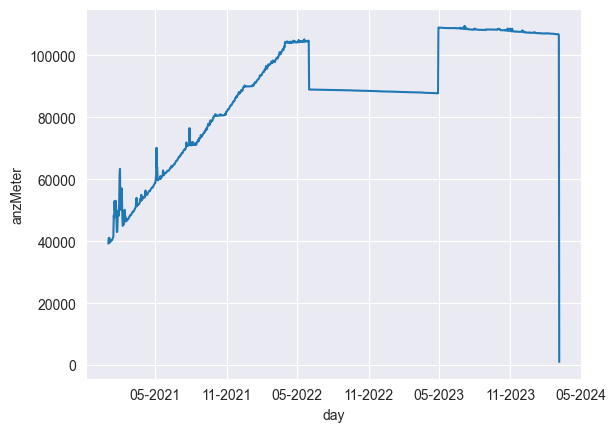

In [39]:
df = pd.read_sql_query("SELECT day, SUM(anzMeter) as anzMeter FROM (SELECT MAX(anzMeter) as anzMeter, STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter GROUP BY PLZ, day) GROUP BY day ORDER BY day;", connection)
df['day'] = pd.to_datetime(df['day'])
plot = sns.lineplot(data=df, x='day', y='anzMeter')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

Ein Vergleich in der Zeit während dem "Tief" und mehr als ein Jahr danach pro Gemeinde zeigt auf, wo die Daten hauptsächlich gefehlt haben. Die nachfolgende Berechnung verdeutlicht, wie viel Prozent der Smartmeter pro Gemeinde keine Daten gesendet haben. Beim Spitzenreiter Udligenswil sind es über 90% der Smartmeter, welche in dem Zeitraum keine Daten gesendet haben.

In [40]:
df = pd.read_sql_query("SELECT a.plz, a.anzMeter AS '2022', b.anzMeter AS '2023', (b.anzMeter - a.anzMeter) AS Differenz, ROUND(100.0 * (b.anzMeter - a.anzMeter) / b.anzMeter, 0) AS MissingPercent FROM (SELECT plz, MAX(anzMeter) AS anzMeter FROM smartmeter WHERE strftime('%Y-%m', timestamp) = '2022-06' GROUP BY plz) AS a LEFT JOIN (SELECT plz, MAX(anzMeter) AS anzMeter FROM smartmeter WHERE strftime('%Y-%m', timestamp) = '2023-11' GROUP BY plz) AS b ON a.plz = b.plz ORDER BY MissingPercent DESC;", connection)
df.head(20)



,plz,2022,2023,Differenz,MissingPercent
0,6044,129,1377,1248,91.0
1,6032,551,4036,3485,86.0
2,6045,626,4556,3930,86.0
3,6246,66,255,189,74.0
4,6020,1681,5736,4055,71.0
5,6231,26,83,57,69.0
6,6247,181,540,359,66.0
7,6026,108,291,183,63.0
8,6235,30,82,52,63.0
9,6242,143,382,239,63.0


Mit diesen Daten lässt sich nun beispielsweise Darstellen, wie der Stromverbrauch in einer Gemeine über die letzten drei Jahre angestiegen ist. Nachfolgende Grafik zeigt die Summe der Kwh einer einzelnen Gemeinde an. Jedoch ist die Aussage der Grafik nicht genau, da über den Zeitraum zusätzliche Smartmeter dazugekommen sind und nicht zwingend mehr Strom in der Gemeinde verbraucht wurde, jedoch immer mehr Smartmeter dazugekommen sind und einen Stromverbrauch melden, welcher zuvor nicht einkalkuliert wurde.

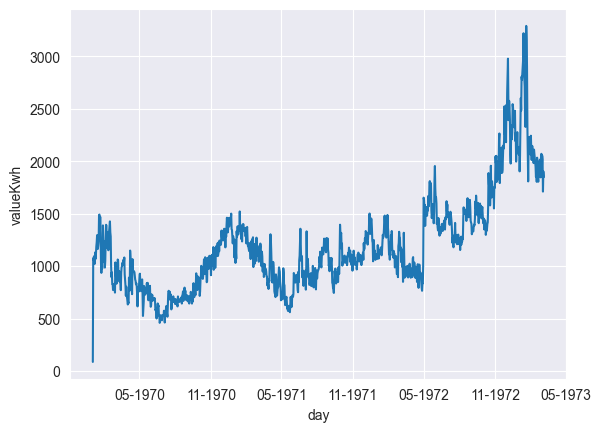

In [41]:
df = pd.read_sql_query("SELECT SUM(valueKwh) as valueKwh, plz,STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter where plz=6016 GROUP BY day;", connection)
plot = sns.lineplot(data=df, x='day', y='valueKwh')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

Eine treffendere Auswertung erhält man jedoch, wenn die Summe der Kwh durch die Anzahl Smartmeter geteilt wird. Damit wird der Zuwachs von Smartmetern kompensiert. Die entsprechende Darstellung zeigt so auch einen deutlich kleineren Wachstum an, als zuvor. Deutlich zu erkennen sind die Schwankungen zwischen Sommer und Winter.

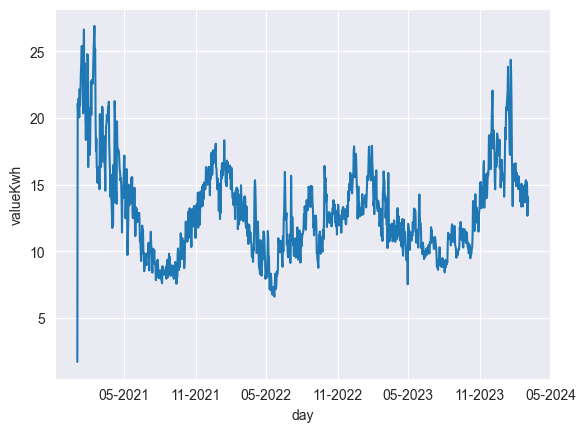

In [42]:
df = pd.read_sql_query("SELECT (SUM(valueKwh) / MAX(anzMeter)) as valueKwh, plz,STRFTIME('%Y-%m-%d', timestamp) as day FROM smartmeter where plz=6016 GROUP BY day;", connection)
df['day'] = pd.to_datetime(df['day'])
plot = sns.lineplot(data=df, x='day', y='valueKwh')
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.show()

In [43]:
#Test Date Time and manipulation

#input = '202001240000'
#output = '%Y%m%d%H%M'

#date = input.strftime('%Y-%m-%d %H:%M')
#date = datetime.datetime.strptime('202001240000', '%Y%m%d%H%M').strftime('%Y-%m-%d %H:%M')

#df = pd.DataFrame({'date':['2020012400', '2020012400']})

#print(df)

#df['date'] += '00'

#print(df)

### Historische Meteo Daten
**Herausgeber:**
Eidgenössisches Departement des Innern (EDI)
Bundesamt für Meteorologie und Klimatologie MeteoSchweiz
Wird zitiert als MeteoSchweiz [Zitierwunsch](https://gate.meteoswiss.ch/idaweb/more.do)

**Link:**
https://gate.meteoswiss.ch/idaweb/more.do

**Beschreibung:**
Die historischen Meteodaten bestehen aus Archivdaten des Bodenmessnetzes von MeteoSchweiz. MeteoSchweiz liefert Messgrössen wie z.B. Niederschlag, Temperatur oder Sonnenstunden. Diese Informationen können Interessant sein, um festzustellen ob diese einen Effekt auf den Stromverbrauch haben. Die Daten können in Zehnminutenwerte, Stundenwerte, Tageswerte, Monatswerte oder Jahreswerte geladen werden. Die Daten können über das Web-Portal IDAWEB zusammengestellt und heruntergeladen werden. (MeteoSchweiz, [Online-Quelle](https://gate.meteoswiss.ch/idaweb/more.do)).

**Zeitraum:**
Es stehen alle Meteodaten seit Messbeginn zu Verfügung. Die Smartmeterdaten stehen für den Zeitraum vom 2020-12-30 00:00 - 2024-03-06 23:00 zu Verfügung. Aus diesem Grund wird für die Meteodaten derselbe Zeitraum gewählt.

**Zweckerfüllung:**
Mit den Meteodaten sollen gewisse Abhängigkeiten festgestellt werden. So wird z.B. erwartet, dass mit zunehmenden Sonnenstunden, der Strombedarf sinkt aufgrund der zahlreichen privaten Solaranlagen. Durch den Niederschlag soll festgestellt werden, ob dieser den Strombedarf positiv oder negativ beeinflusst auch in Kombination mit der Temperatur. Hat der Niederschlag einen merkbaren Einfluss, wenn in einem vergleichbaren Zeitraum die Temperatur gleich bleibt.
Diese drei Parameter werden auf stündlicher Basis für den gewählten Zeitraum geladen.  Folgende Parameter werden erhoben:
- Niederschlag, Stundensumme in Millimeter
- Lufttemperatur 2m über Boden, Stundenmittel in Grad Celsius
- Sonnenscheindauer, Stundensumme in Minuten

Im Grundsatz werden die Anforderungen damit erfüllt.

**Qualität (Glaubwürdigkeit, Nützlichkeit, Interpretierbarkeit, Schlüsselintegrität):**

*Glaubwürdigkeit:* Die Glaubwürdigkeit ist gegeben, da es sich um die offizielle Meteo Stationen des Bundes handelt. Neben den Daten des Bundes stand die Quelle [Open-Meteo.com](https://open-meteo.com/en/docs/historical-weather-api) als API zur Auswahl. Auf diese wurde verzichtet. Dies aus den Gründen, dass die historischen Daten basierend auf Wetterstationen, Flugzeugen, Boyen, Radar und Satelliten Beobachtungen berechnet werden und nicht klar ist, wie genau diese Daten sind. Eine weitere Unsicherheit ist, dass die verwendeten Datasets auf Mittel- bis Langvorhersagen ausgerichtet sind sowie einen globalen Fokus haben [Open-Meteo.com](https://open-meteo.com/en/docs/historical-weather-api). Da im Projektteam die meteorologische Expertise fehlt zur Verifizierung wie gut diese Daten sind, werden die Daten von MeteoSchweiz verwendet.

*Nützlichkeit:* Das IDAWEB Portal von MeteoSchweiz stellt die Messdaten von Messstationen zu Verfügung. Damit entsteht die Schwierigkeit, dass nicht pro BFS-ID oder PLZ direkt die gewünschten Messdaten zu Verfügung stehen. Während des Abfrageprozesses, müssen zuerst die potenziellen Messstationen ausgewählt werden. Danach folgen die gewünschten Messparameter sowie der Zeitraum. Daraus ergibt sich ein Set an Messdaten welches zu Verfügung steht. Beim Niederschlag steht eine gute Menge an Messtationen zu Verfügung, welche den Kanton Luzern gut abdecken. Im Bereich der Sonnenstunden und Temperatur ist dies jedoch nicht der Fall. Bei den Sonnenstunden gibt es generell kaum Messstationen. Bei der Temperatur gibt es verschiedene Messhöhen z.B. direkt am Boden, 5cm ab Boden oder 2m ab Boden. Teilweise wird auch keine Höhe angegeben. Die Messtationen mit einer Messhöhe von 2m erfüllen den internationalen Standard und sind dabei nicht der Witterung oder Sonnenstrahlung ausgesetzt, welche die Messwerte verfälschen würden (MeteoSchweiz, [Online-Quelle](https://www.meteoschweiz.admin.ch/wetter/wetter-und-klima-von-a-bis-z/temperatur.html)). 
Die geografische Abdeckung der Temperatur Messtationen mit 2m Höhe ist nicht flächendeckend. Bei den Temperatur Messstationen ohne Höhen Angabe, gibt es eine breitere Abdeckung jedoch mit der Ungewissheit, wie die Temperaturen gemessen werden. Je nach Position können grössere Schwankungen auftreten. Aus diesem Grund werden die Meteostationen gewählt, welche die Temperatur 2 Meter über dem Boden messen. Damit ist eine einheitliche Messmethodik gewährleistet und die Vergleichbarkeit gegeben. Damit die Daten nutzbar eingesetzt werden können, wird aufgrund der geografischen Position der Messstation die BFS-ID zugeordnet. Dies erfolgt manuell in einer gesonderten CSV-Datei. Die geografische Verteilung und Zuordnung folgt in der Analyse.

*Interpretierbarkeit:* Nachdem die gewünschten Parameter gewählt wurden, werden die Messdaten exportiert. Es wird pro Messstation und Parameter eine TXT-Datei mit einer Legende erstellt und eine mit den Messdaten. Insgesamt sind dies 370 TXT-Dateien. In der Legende werden jeweils die Meteostation beschrieben mit der Bezeichnung, Parameter, Koordinate und ID. Zusätzlich gibt es ein Beschreibung zum Parameter. Aufgrund des TXT-Formats und keinen Trennzeichen wurden die Meteostationen manuell in der Datei meteoStation.csv erfasst. Dasselbe gilt für die drei Parameter. Die wurden manuell in die Datei parameter.csv geschrieben. Die Messstationen verfügen über keine PLZ oder BFS-ID, daher werden diese Informationen manuell in der CSV-Datei ergänzt.
Die Messdaten TXT-Datei beinhaltet die Station-ID, Zeitstempel sowie den Wert, des Parameters. Die Bezeichnung des Parameters steht in der Spaltenbezeichnung. Es besteht viel manueller Aufwand und die Maschinen lesbarkeit ist nur bei den Messdaten TXT-Dateien gegeben. Daher ist die Interpretierbarkeit für den hier benötigten Kontext nur mit manuellem Aufwand gegeben. Zur Sicherung in der Datenbank, müssen die Daten angereichert werden damit die Daten später wieder korrekt zusammengesetzt werden können.

*Schlüsselintegrität:* Die Messdaten TXT-Dateien haben aber keinen Primary Key, besitzen aber die Foreign-Key's der Messstationen-ID sowie der Parameter-ID. Damit lassen sich die Messdaten wieder zusammensetzen. Damit pro BFS-ID alle drei Parameter geladen werden können, wird eine Mapping-Tabelle benötigt welche jeweils die BFS-ID jeweils mit dem gewünschten Parameter der geografisch nächsten Meteostation verbindet.

**Verfügbarkeit:** Die Daten stehen für Forschungs- und Lehrzwecke allen zu Verfügung. Es ist ein Registrierungsprozess notwendig, um Zugriff auf die Daten zu erhalten.

**Preis:** Im Kontext von Forschungs- und Lehrzwecken können die Daten kostenlos genutzt werden. Eine kommerzielle Nutzung ist untersagt. Die Verwendung der Daten für Grafiken, Text oder Vorträge ist erlaubt mit entsprechender Kennzeichnung der Quelle mit MeteoSchweiz. (MeteoSchweiz, [Online-Quelle](https://gate.meteoswiss.ch/idaweb/more.do))

#### Inhaltliche Analyse und Schwierigkeiten 
Die manuell aufbereitete CSV Datei "parameter" beinhaltet drei Einträge und drei Spalten. Die parameterID gibt den gemessenen Wert an. Mit measure wird die Masseinheit angegeben und in der Spalte description wird spezifiert, was gemessen wurde und in welchen Zeitintervall.

In [44]:
#Import Meteo Parameter
meteoParameter = pd.read_csv("./DATA/meteo/parameter.csv", delimiter=";")
meteoParameter.info()
meteoParameter.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   parameterID  3 non-null      object
 1   measure      3 non-null      object
 2   description  3 non-null      object
dtypes: object(3)
memory usage: 200.0+ bytes


,parameterID,measure,description
0,rre150h0,mm,"Niederschlag, Stundensumme"
1,tre200h0,celsius,"Lufttemperatur 2 m ueber Boden, Stundenmittel"
2,sre000h0,min,"Sonnenscheindauer, Stundensumme"


Nachfolgend wird die Datei in die Datenbank gelesen.

In [45]:
meteoParameter["parameterID"] = '"' + meteoParameter["parameterID"] + '"'
meteoParameter["measure"] = '"' + meteoParameter["measure"] + '"'
meteoParameter["description"] = '"' + meteoParameter["description"] + '"'
for index, row in meteoParameter.iterrows():
    sql = "INSERT INTO meteoParameter VALUES({}, {}, {})".format(row["parameterID"], row["measure"], row["description"])
    cursor.execute(sql)

connection.commit()

Diese CSV-Datei meteoStation.csv wurde manuell erstellt. Dazu mussten die jeweiligen Legenden-Einträge von jedem Daten-Export einzeln kopiert werden und in die CSV-Datei integriert werden. Die stn ist die jeweilige ID der Meteostation. Jede Station verfügt über einen expliziten Namen (stnName) sowie Betreiber/Herausgeber der Messdaten (datasource). Damit bekannt ist wo sich die Meteostationen befinden, werden die Koordinaten mitgegeben. Mit coLength/coWide werden die Koordinaten in einem internationalen Format angegeben auch bekannt als WGS84 welche für das GPS verwendet wird. Die Attribute coEast/coNorth beschreiben die Koordinaten in dem Schweizer LV03 Format.
Für die weitere Verarbeitung und Verknüpfung der Daten muss nun die BFS-ID (bfs-Id) sowie der Gemeindenamen (lawCityName) manuell hinzugefügt werden. Dazu wurde die Online Karte von Swisstopo (https://map.geo.admin.ch/) verwendet mit den entsprechend eingeblendeten Gemeindegrenzen. Dadurch konnte visuell erkannt werden, welche Meteostation zu welcher Gemeinde gehört.

In [46]:
meteoStations = pd.read_csv("./DATA/meteo/meteoStation.csv", delimiter=";")
meteoStations.info()
meteoStations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   stn          75 non-null     object
 1   stnName      75 non-null     object
 2   lawCityName  75 non-null     object
 3   datasource   75 non-null     object
 4   bfsId        75 non-null     int64 
 5   coEast       75 non-null     int64 
 6   coNorth      75 non-null     int64 
 7   coLength     75 non-null     object
 8   coWide       75 non-null     object
dtypes: int64(3), object(6)
memory usage: 5.4+ KB


,stn,stnName,lawCityName,datasource,bfsId,coEast,coNorth,coLength,coWide
0,ZGGRE,Greppen,Greppen,Gewässerschutzverband der Region Zugersee-Küss...,1056,675282,212747,8°26',47°04'
1,ZELUZI,Zinggen,Greppen,Kanton Luzern; zentras,1056,645418,202081,8°02',46°58'
2,ZELUWK,Wikon,Wikon,Kanton Luzern; zentras,1147,639947,234508,7°58',47°16'
3,ZELUWI,Wikon,Escholzmatt-Marbach,Kanton Luzern; zentras,1010,636014,193238,7°55',46°53'
4,ZELUWE,Weggis,Weggis,Kanton Luzern; zentras,1069,674923,210861,8°25',47°03'


Während der Selektion der Daten wurde die Problematik der nicht flächendeckenden Abdeckung erkannt. Insgesamt stehen 75 Messstationen zu Verfügung. Mit dem Import wird klar, dass zu 50 Gemeinden eine eindeutige Messtation zugeteilt werden konnte. Somit besteht ein Delta von 30 Gemeinden, die keine direkte Messstation haben. Was auch klar wird, ist dass manchen Gemeinden über mehrere Stationen verfügen. Emmen verfügt als Spitzenreiter über fünf Messstationen. Die verfügbaren Messungen an diesen Stationen wurde bisher noch nicht berücksichtigt. 

In [47]:
print('Anzahl Messstationen: ', meteoStations['stn'].nunique())
print('Anzahl eindeutige BFS-ID: ', meteoStations['bfsId'].nunique())
cityLu_df = city_df.query("Kantonskürzel == 'LU'")
print("Anz. Eindeutige BFS-Nr im Kanton Luzern:", cityLu_df['BFS-Nr'].nunique())
meteoStations[["lawCityName", "stn"]].groupby('lawCityName').count().sort_values(by=['stn'], ascending=False)

Anzahl Messstationen:  75
Anzahl eindeutige BFS-ID:  50
Anz. Eindeutige BFS-Nr im Kanton Luzern: 80


,stn
lawCityName,
Emmen,5
Malters,3
Escholzmatt-Marbach,3
Luzern,3
Schüpfheim,3
Reiden,2
Neuenkirch,2
Menznau,2
Kriens,2


Nachfolgend werden die Daten in die Datenbank eingelesen.

In [48]:
meteoStations["stn"] = '"' + meteoStations["stn"] + '"'
meteoStations["stnName"] = '"' + meteoStations["stnName"] + '"'
meteoStations["lawCityName"] = '"' + meteoStations["lawCityName"] + '"'
meteoStations["datasource"] = '"' + meteoStations["datasource"] + '"'
meteoStations["coLength"] = '"' + meteoStations["coLength"] + '"'
meteoStations["coWide"] = '"' + meteoStations["coWide"] + '"'

for index, row in meteoStations.iterrows():
    sql = "INSERT INTO meteoStations VALUES({}, {}, {}, {}, {}, {}, {}, {}, {})".format(row["stn"], row["stnName"], row["lawCityName"], row["datasource"], row["bfsId"], row["coEast"], row["coNorth"], row["coLength"], row["coWide"])
    cursor.execute(sql)

connection.commit()

Nun werden die Messdaten eingelesen. Diese geschieht pro Parameter. Alle Messungen setzen sich aus der Messstation (stn), dem Zeitstempel (time) und dem Wert (parameterName z.B. rre150h0) zusammen. Gestartet wird mit den Regendaten. Das sind 1,95 Millionen Messungen. Davon sind 60605 NA Werte und die Niederschlagsdaten sind über 71 Messstationen verfügbar. Das entspricht einer guten Abdeckung. Die NA Werte werden nun weiter untersucht.

In [49]:
#Import MeteoData of parameter rre150h0
#Files bereinigen mit den ersten zwei Zeilen jeder Datei überspringen
#Datum umformatieren damit SQLite dies interpretieren kann
path = './DATA/meteo/data'
csv_files = glob.glob(path + '/*rre150h0*data.txt')
df_list = (pd.read_csv(file, delimiter=';', na_values= '-') for file in csv_files)

meteo_df = pd.concat(df_list, ignore_index=True)

meteo_df.info()
print("\nAnzahl leere Werte:\n", meteo_df.count())

print("\nAnzahl eindeutige Messstationen: ", meteo_df['stn'].nunique())
meteo_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954434 entries, 0 to 1954433
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   stn       object 
 1   time      int64  
 2   rre150h0  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 44.7+ MB

Anzahl leere Werte:
 stn         1954434
time        1954434
rre150h0    1893829
dtype: int64

Anzahl eindeutige Messstationen:  71


,stn,time,rre150h0
0,ZELURU,2020123000,0.0
1,ZELURU,2020123001,0.0
2,ZELURU,2020123002,0.0
3,ZELURU,2020123003,0.0
4,ZELURU,2020123004,0.0


Wie aus der Analyse entnommen werden kann, liefern von 71 Stationen nur 5 vollständige Daten. 66 Stationen haben lücken in ihren Daten. Da es sich hier um die Niederschlagsmenge in der Stundensumme handelt, sind 4707 fehlende Stundenangaben schon signifikant. Das entspricht umgerechnet ca. 196 Tage fehlende Daten. 

In [50]:
meteoNA_df = meteo_df[meteo_df['rre150h0'].isna()]
meteoNA_df[['rre150h0']].isna().groupby(meteoNA_df['stn']).sum().sort_values(by=['rre150h0'], ascending=False)


,rre150h0
stn,
ZELUHR,4707
ZELUTB,4478
ZELUBU,3435
ZELUHW,2697
ZELUWK,2651
...,...
LUROO,146
LUHOC,130
LUZ,50


In [51]:
df = []
plt.clf()

<Figure size 640x480 with 0 Axes>

<class 'pandas.core.frame.DataFrame'>
Index: 27912 entries, 519740 to 895852
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   stn       27912 non-null  object        
 1   time      27912 non-null  datetime64[ns]
 2   rre150h0  23205 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 872.2+ KB


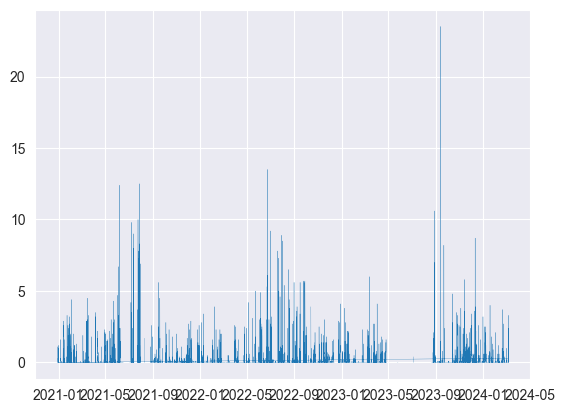

In [52]:

df = meteo_df[meteo_df['stn'] == 'ZELUHR'].copy()
#df.sort_values(by='time')
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
#df.dropna(inplace=True)
df.info()
df = df.set_index(df.time)
#df.drop(columns='stn', inplace=True)
#df['rre150h0' == 'NaN'] = np.nan
#df.replace(np.nan, -20, inplace=True)
plt.plot(df.time, df.rre150h0, linewidth=0.2)


#meteoNAplot = sns.lineplot(data=df, x='time', y='rre150h0', color= 'red')
#meteoNAplot.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
#meteoNAplot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()
#df.info()
#meteoNA_df.head()


In [53]:


#meteo_df.replace(np.nan, "NULL", inplace=True)
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df['time'] = pd.to_datetime(meteo_df.time)
meteo_df['time'] = meteo_df['time'].dt.strftime('%Y-%m-%d %H:%M')

meteo_df['time'] = '"' + meteo_df['time'] + '"'
meteo_df['stn'] = '"' + meteo_df['stn'] + '"'


for index, row in meteo_df.iterrows():
    sql = "INSERT INTO meteoData VALUES(NULL,{},{},{},{})".format(row["stn"], '"rre150h0"', row["time"], row["rre150h0"])
    cursor.execute(sql)

connection.commit()

OperationalError: no such column: nan

In [ ]:
#Import MeteoData of parameter tre200h0
path = './DATA/meteo/data'
csv_files = glob.glob(path + '/*tre200h0*data.txt')
df_list = (pd.read_csv(file, delimiter=';', na_values= '-') for file in csv_files)

meteo_df = pd.concat(df_list, ignore_index=True)
meteo_df.replace(np.nan, "NULL", inplace=True)
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df['time'] = pd.to_datetime(meteo_df.time)
meteo_df['time'] = meteo_df['time'].dt.strftime('%Y-%m-%d %H:%M')

meteo_df['time'] = '"' + meteo_df['time'] + '"'
meteo_df['stn'] = '"' + meteo_df['stn'] + '"'

for index, row in meteo_df.iterrows():
    sql = "INSERT INTO meteoData VALUES(NULL,{},{},{},{})".format(row["stn"], '"tre200h0"', row["time"], row["tre200h0"])
    cursor.execute(sql)

connection.commit()

In [ ]:
#Import MeteoData of parameter sre000h0
path = './DATA/meteo/data'
csv_files = glob.glob(path + '/*sre000h0*data.txt')
df_list = (pd.read_csv(file, delimiter=';', na_values= '-') for file in csv_files)

meteo_df = pd.concat(df_list, ignore_index=True)
meteo_df.replace(np.nan, "NULL", inplace=True)
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df = meteo_df.astype({'time': str})
meteo_df['time'] = meteo_df['time'] + '00'
meteo_df['time'] = pd.to_datetime(meteo_df.time)
meteo_df['time'] = meteo_df['time'].dt.strftime('%Y-%m-%d %H:%M')

meteo_df['time'] = '"' + meteo_df['time'] + '"'
meteo_df['stn'] = '"' + meteo_df['stn'] + '"'

for index, row in meteo_df.iterrows():
    sql = "INSERT INTO meteoData VALUES(NULL,{},{},{},{})".format(row["stn"], '"sre000h0"', row["time"], row["sre000h0"])
    cursor.execute(sql)

connection.commit()

In [ ]:
#Import MeteoParamBFS
meteoParams = pd.read_csv("./DATA/meteo/meteoStationBfsParameter.csv", delimiter=";")

meteoParams["meteoParameter"] = '"' + meteoParams["meteoParameter"] + '"'
meteoParams["meteoStation"] = '"' + meteoParams["meteoStation"] + '"'

for index, row in meteoParams.iterrows():
    sql = "INSERT INTO meteoParamBfs VALUES(NULL, {}, {}, {})".format(row["bfsID"], row["meteoParameter"], row["meteoStation"])
    cursor.execute(sql)

connection.commit()